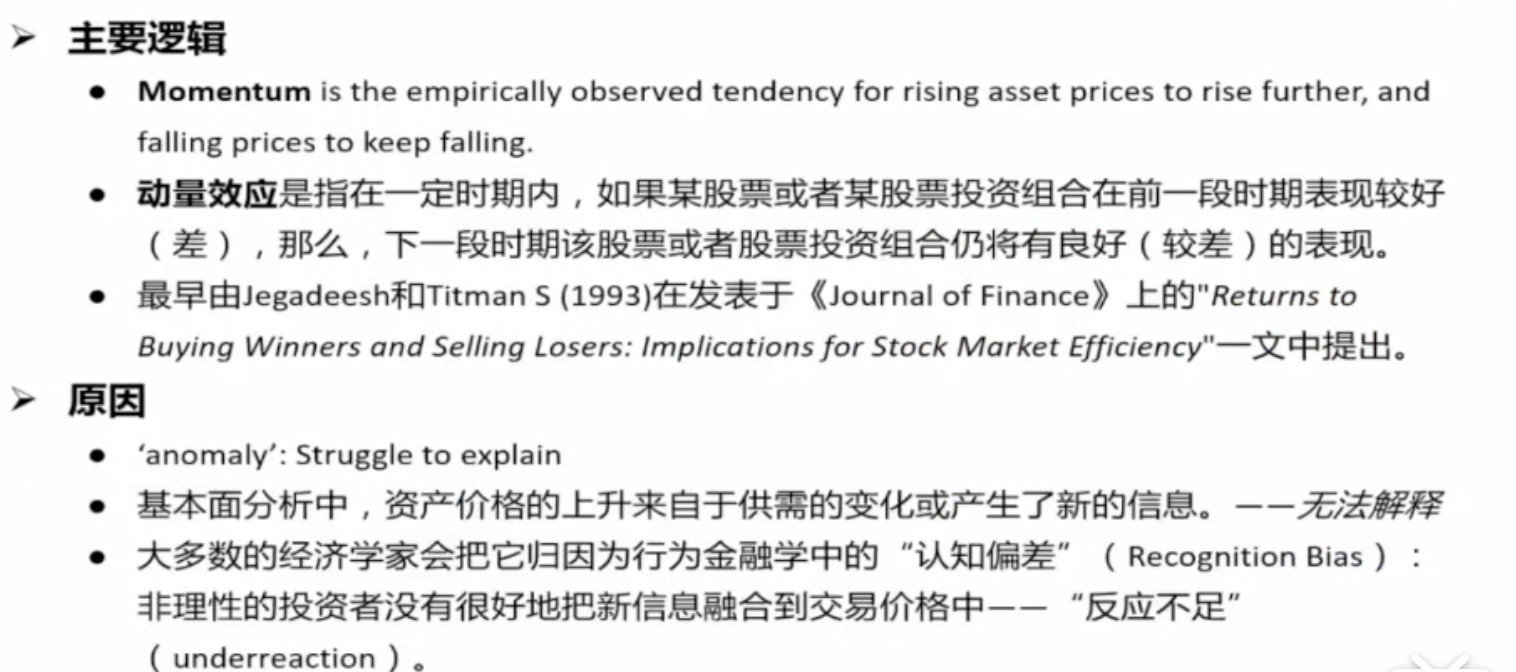

momentum分为两种：time-seties、cross-sectional

strategy: 过去n天涨——long，过去n天跌——short；

        参数优化——选择n，穷举

### 1 数据准备&回测准备

In [1]:
import numpy as np
import pandas as pd
import tushare as ts

In [2]:
data = ts.get_k_data('hs300','2010-01-01','2017-06-27')[['date','close']]
data = pd.DataFrame(data)
data.rename(columns={'close':'price'},inplace=True)
data.set_index('date',inplace=True)
data.head()

,price
date,
2010-01-04,3535.229
2010-01-05,3564.038
2010-01-06,3541.727
2010-01-07,3471.456
2010-01-08,3480.130


### 2 策略开发思路

In [5]:
data['returns'] = np.log(data['price']/data['price'].shift(1))
data['position'] = np.sign(data['returns']) #sign()函数：正为1，负为-1
data.head(5)
# position要收盘之后才能知道，所以实际上是后一天的头寸

,price,returns,position
date,,,
2010-01-04,3535.229,NaN,NaN
2010-01-05,3564.038,0.008116,1.0
2010-01-06,3541.727,-0.006280,-1.0
2010-01-07,3471.456,-0.020040,-1.0
2010-01-08,3480.130,0.002496,1.0


In [6]:
data['strategy'] = data['position'].shift(1) * data['returns']
data.head(10)

,price,returns,position,strategy
date,,,,
2010-01-04,3535.229,NaN,NaN,NaN
2010-01-05,3564.038,0.008116,1.0,NaN
2010-01-06,3541.727,-0.006280,-1.0,-0.006280
2010-01-07,3471.456,-0.020040,-1.0,0.020040
2010-01-08,3480.130,0.002496,1.0,-0.002496
2010-01-11,3482.052,0.000552,1.0,0.000552
2010-01-12,3534.916,0.015068,1.0,0.015068
2010-01-13,3421.144,-0.032715,-1.0,-0.032715
2010-01-14,3469.051,0.013906,1.0,-0.013906


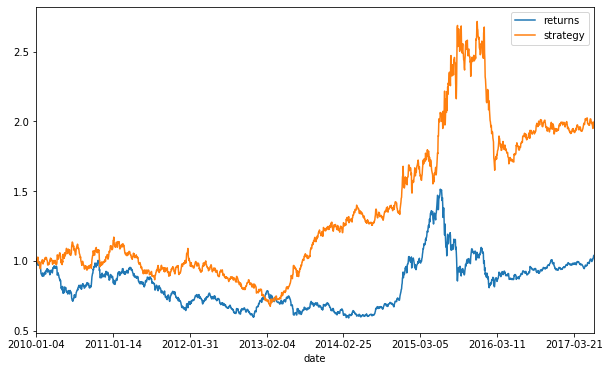

In [8]:
data[['returns','strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))

### 3 计算收益

In [12]:
data['strategy'].mean() *252

0.0961101425247989

In [13]:
data['strategy'].std() * 252**0.5

0.24446534068735415

### 4 策略优化——参数优化&穷举

问题：过于频繁地买卖开仓，考虑手续费后收益不高甚至亏损

In [19]:
# 5天移动平均:更稳定，降低交易成本
data['position2'] = np.sign(data['returns'].rolling(5).mean())
data['position2'].fillna(0,inplace=True)
data.head(10)

,price,returns,position,strategy,position2
date,,,,,
2010-01-04,3535.229,NaN,NaN,NaN,0.0
2010-01-05,3564.038,0.008116,1.0,NaN,0.0
2010-01-06,3541.727,-0.006280,-1.0,-0.006280,0.0
2010-01-07,3471.456,-0.020040,-1.0,0.020040,0.0
2010-01-08,3480.130,0.002496,1.0,-0.002496,0.0
2010-01-11,3482.052,0.000552,1.0,0.000552,-1.0
2010-01-12,3534.916,0.015068,1.0,0.015068,-1.0
2010-01-13,3421.144,-0.032715,-1.0,-0.032715,-1.0
2010-01-14,3469.051,0.013906,1.0,-0.013906,-1.0


In [20]:
data['strategy2'] = data['position2'].shift(1) *data['returns']
data.head(10)

,price,returns,position,strategy,position2,strategy2
date,,,,,,
2010-01-04,3535.229,NaN,NaN,NaN,0.0,NaN
2010-01-05,3564.038,0.008116,1.0,NaN,0.0,0.000000
2010-01-06,3541.727,-0.006280,-1.0,-0.006280,0.0,-0.000000
2010-01-07,3471.456,-0.020040,-1.0,0.020040,0.0,-0.000000
2010-01-08,3480.130,0.002496,1.0,-0.002496,0.0,0.000000
2010-01-11,3482.052,0.000552,1.0,0.000552,-1.0,0.000000
2010-01-12,3534.916,0.015068,1.0,0.015068,-1.0,-0.015068
2010-01-13,3421.144,-0.032715,-1.0,-0.032715,-1.0,0.032715
2010-01-14,3469.051,0.013906,1.0,-0.013906,-1.0,-0.013906


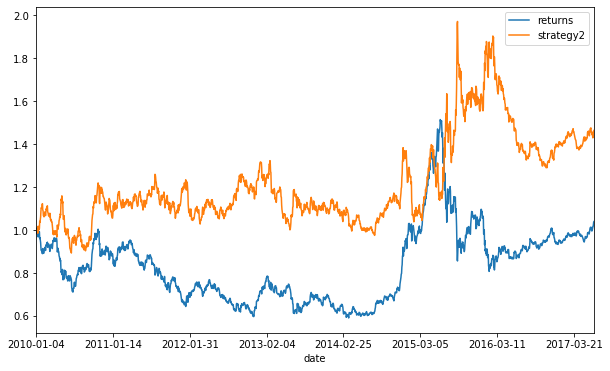

In [21]:
data[['returns','strategy2']].cumsum().apply(np.exp).plot(figsize=(10,6))

In [22]:
data['strategy2'].mean() *252

0.05293329902664395

#### 参数寻优——使用离散return

In [23]:
data['return_dis'] = data['price']/data['price'].shift(1) -1
data['return_dis_cum'] = (data['return_dis']+1).cumprod()
data.head()

,price,returns,position,strategy,position2,strategy2,return_dis,return_dis_cum
date,,,,,,,,
2010-01-04,3535.229,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2010-01-05,3564.038,0.008116,1.0,NaN,0.0,0.0,0.008149,1.008149
2010-01-06,3541.727,-0.006280,-1.0,-0.006280,0.0,-0.0,-0.006260,1.001838
2010-01-07,3471.456,-0.020040,-1.0,0.020040,0.0,-0.0,-0.019841,0.981961
2010-01-08,3480.130,0.002496,1.0,-0.002496,0.0,0.0,0.002499,0.984414


In [28]:
price_plot=['return_dis_cum']

In [33]:
for days in [10,20,30,40,50,60]:
    price_plot.append('sty_cumr_%dd' % days)
    data['position_%dd' % days] = np.where(days['returns'].rolling(days).mean()>0,1,-1)
    data['strategy_%dd' % days] = data['position_%dd' % days].shift(1) * data['returns']
    data['sty_cumr_%dd' % days] = (data['strategy_%dd' % days]+1).cumprod()     

TypeError: 'int' object is not subscriptable

In [30]:
data[price_plot].dropna().plot(
    title='HS300 Multi Parameters Momentuem Strategy',
    figsize = (10,6),style=['--','--','--','--','--','--','--'])

KeyError: "['sty_cumr_10d'] not in index"